In [1]:
%%capture
!pip install dowhy

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
import dowhy
import dowhy.api
import dowhy.datasets
import dowhy.plotter

# Causal Inference with DoWhy

By Alessio Zanga and Fabio Stella

## Abstract

This notebook represents a quick-start guide to causal inference using the [DoWhy](https://github.com/microsoft/dowhy) package.

## Generate a Dataset

DoWhy allows the generation of a dataset by specifying a set of parameters.

In [4]:
dataset = dowhy.datasets.linear_dataset(
    beta = 1,
    num_samples = int(1e4),
    num_common_causes = 1,
    num_frontdoor_variables = 1,
    treatment_is_binary = True,
    outcome_is_binary = True
)
list(dataset.keys())

['df',
 'treatment_name',
 'outcome_name',
 'common_causes_names',
 'instrument_names',
 'effect_modifier_names',
 'frontdoor_variables_names',
 'dot_graph',
 'gml_graph',
 'ate']

It will return a dictionary with a Pandas DataFrame, along with a set of variables names and the true causal graph used for the sampling process.

In [5]:
data, [treatment_name], outcome_name, _, _, _, _, _, causal_graph, ace = dataset.values()

After unpacking the values of the dictionary, it is possible to observe the assigned names to the data columns:

In [6]:
treatment_name, outcome_name

('v0', 'y', 0.0085)

It also return the true average causal effect:

In [15]:
ace

In [7]:
data

FD0        W0     v0      y
0    -2.299456 -0.646246  False   True
1     0.116240  1.698779  False   True
2     0.528497 -0.533785   True  False
3     0.220552  1.428394   True  False
4     1.001270  1.035299  False   True
...        ...       ...    ...    ...
9995 -0.779261 -1.180635  False   True
9996 -1.328995 -0.814055  False  False
9997 -0.136533 -0.499297  False   True
9998  0.283147 -0.651132  False  False
9999  0.340957  0.041296  False  False

[10000 rows x 4 columns]

## Construct a Model

The second step consists in constructing a causal model using the true graph.

In [8]:
model = dowhy.CausalModel(
    data = data,
    treatment = treatment_name,
    outcome = outcome_name,
    graph = causal_graph
)

It is not a proper SCM as we seen in previous sessions. It is more like a container for the data and the graph.

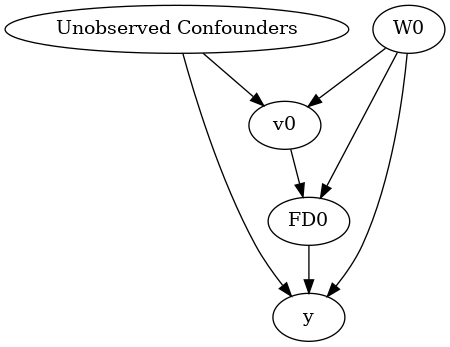

In [9]:
model.view_model(layout="dot")
from IPython.display import Image, display
display(Image(filename="causal_model.png"))

This will enable the identification step by using a couple of handful methods.

## Identify the Estimand

The estimand identification tests for both backdoor and frontdoor criterion.

In [10]:
estimand = model.identify_effect(proceed_when_unidentifiable=True)
print(estimand)

Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                     
─────(Expectation(y|W0))
d[v₀]                   
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

### Estimand : 2
Estimand name: iv
No such variable found!

### Estimand : 3
Estimand name: frontdoor
Estimand expression:
Expectation(Derivative(y, [FD0])*Derivative([FD0], [v0]))
Estimand assumption 1, Full-mediation: FD0 intercepts (blocks) all directed paths from v0 to y.
Estimand assumption 2, First-stage-unconfoundedness: If U→{v0} and U→{FD0} then P(FD0|v0,U) = P(FD0|v0)
Estimand assumption 3, Second-stage-unconfoundedness: If U→{FD0} and U→y then P(y|FD0, v0, U) = P(y|FD0, v0)



## Estimate the Average Causal Effect

Once the estimand has been identified, we can proceed to the last estimation step.

In [11]:
methods = [
    "backdoor.linear_regression",
    "backdoor.propensity_score_stratification",
    "backdoor.propensity_score_weighting",
    "backdoor.propensity_score_matching",
]

We will iterate over the provided methods and compare the results.

In [12]:
estimates = {
    method: model.estimate_effect(estimand, method_name=method)
    for method in methods
}

In [13]:
for estimate in estimates.values():
    print(estimate)
    break

*** Causal Estimate ***

## Identified estimand
Estimand type: nonparametric-ate

### Estimand : 1
Estimand name: backdoor
Estimand expression:
  d                     
─────(Expectation(y|W0))
d[v₀]                   
Estimand assumption 1, Unconfoundedness: If U→{v0} and U→y then P(y|v0,W0,U) = P(y|v0,W0)

## Realized estimand
b: y~v0+W0
Target units: ate

## Estimate
Mean value: 0.005232929977916689



In [14]:
for method, estimate in estimates.items():
    print(f"""
    Estimation Method: {method},
    Estimated ACE: {estimate.value:.4},
    Relative Error: {(abs((estimate.value-ace)/ace*100)):.4}%
    """.lstrip("\n"))

    Estimation Method: backdoor.linear_regression,
    Estimated ACE: 0.005233,
    Relative Error: 38.44%
    
    Estimation Method: backdoor.propensity_score_stratification,
    Estimated ACE: 0.007281,
    Relative Error: 14.34%
    
    Estimation Method: backdoor.propensity_score_weighting,
    Estimated ACE: 0.006791,
    Relative Error: 20.1%
    
    Estimation Method: backdoor.propensity_score_matching,
    Estimated ACE: 0.0116,
    Relative Error: 36.47%
    


Your results may vary. Try to experiment with different graph configurations by altering the numbers of variables in the generation step. Have fun!